# Prediction: Pop vs. Rap

This notebook explores various algorithms' ability to classify songs as pop or rap. We also develop a classification technique based on comparing word distributions. Finally, we summarize all the results and end with a discussion.

In [1]:
import sys
sys.path.insert(0, "..//..//..//scripts")

import xgboost as xgb
import seaborn as sns
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from NonParametricClassifier import *
from CDFClassifier import *
from HelperFunctions import *
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

First, we read in the data and define genres. These genres are not disjoint; many songs have both Pop and Rap within their genre column. We wanted to account for this overlap so we created one column for each genre. Moreover, we removed words based on their Gini index which is defined as

$$G(w) = \sum^k_{i = 1} p_i(w)^2$$

where $p_i(w)$ is the probability of the word occurring in genre $w$ and $k$ is the number of genres. The Gini index lies between $\left(\frac{1}{k}, 1\right)$ and lower Gini indexes correspond with a more uniform distribution over all genres. Thus, removing words with low Gini indexes leaves us with words that are not uniformly distributed over all genres, increasing the discriminative power of our classification algorithms. Since we have four different genre combinations, the minimum Gini index is .25. We remove the bottom 3.2% of words.

In [2]:
df = pd.read_csv("..//..//..//..//data//Weekly_data_tokenized.csv")

df["Pop"] = df.apply(lambda row: create_genre(row, "pop"), axis = 1)
df["Rap"] = df.apply(lambda row: create_genre(row, "rap"), axis = 1)

df = df[["word", "ID", "Pop", "Rap"]]

tmp = df.groupby(["word", "Pop", "Rap"]).count().unstack().unstack().fillna(0)

gini = calculate_gini_index(tmp)
useless_words = [x for x in gini if gini[x] <= .32]

df = df[~df.word.isin(useless_words)]

In [3]:
len(useless_words) / len(df.word.unique())

0.03215836952890077

We now split our data into training and validation sets. We opted for a 80-20 split.

In [4]:
np.random.seed(1)

IDs = df.ID.unique()
np.random.shuffle(IDs)

train = df[df.ID.isin(IDs[:int(.8 * len(IDs))])]
test = df[df.ID.isin(IDs[int(.8 * len(IDs)):])]

# Classification by distribution comparison

The basic idea behind our classification technique is this: Build empirical word distributions for each genre using the training set. This means for each genre, count the number of times a word shows up and normalize by the sum of word frequencies to create a probability distribution. For each validation example, create the example's word distribution and compute the distance between the example's distribution and each genre's word distribution. The genre associated with the minimum distribution difference is assigned to the validation example.

More formally, let $P_1, \cdots, P_k$ be the probability mass functions of words for each class and let $X$ be the support of each PMF. Let $d: X \times X \rightarrow \mathbb{R}$ be a distance function between two PMF's. For each training example with PMF $P$ we wish to find

$$c = \text{argmin}_i \  d(P, P_i)$$

We try two different distance functions: KL Divergence and Hellinger.

### KL Divergence

The KL divergence between two PMF's $f$ and $g$ is $$d(f, g) = \sum_{w \in X}f(w) \log \frac{f(w)}{g(w)}$$ In our case, we can think of $f$ as the validation example's PMF we wish to test and $g$ as the empirical distribution of a genre. Because there are words in the validation set that do not exist in the training set, we introduce a smoothing parameter $\alpha$ in place of $g(w)$ when $g(w) = 0$:

$$d(f(w), g(w)) = \begin{cases}f(w) \log \frac{f(w)}{g(w)} & \mbox{if } g(w) > 0 \\
f(w) \log \frac{f(w)}{\alpha} & \mbox{if } g(w) = 0\end{cases}$$

Below is a graph of our accuracy while grid searching over values of $\alpha$ between $0.00000001$ and $0.0001$. Our maximum accuracy with this method is 82.6%. We find that $\alpha = 3.025 \times 10^{-6}$ maximizes accuracy. This makes sense because $\alpha$ should be at least the minimum probability of a word (or even smaller) of the genres' empirical distributions.

Best accuracy: 0.8261538461538461
Parameter 3.024773869346734e-06


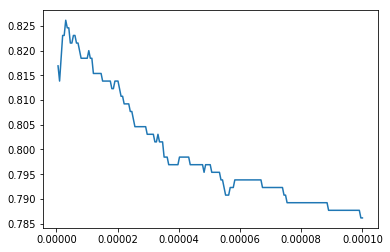

In [5]:
klgrid = grid_search_nonparametric(0.00000001, 0.0001, 200, NonParametricClassifier, train, test, ["Pop", "Rap"], "KL", False)

### Hellinger

The Hellinger distance between two PMF's $f$ and $g$ is 

$$d(f, g) = \left[\sum_{w \in X}\left(\sqrt{f(w)} - \sqrt{g(w)}\right)^2\right]^{1/2}$$

Unlike before, we do not smooth this distance when $g(w) = 0$. However, we do generalize this distance to a similar form as the $\ell_p$ norm:

$$d_p(f, g) = \left[\sum_{w \in X}\left({f(w)}^{\frac{1}{p}} - {g(w)}^{\frac{1}{p}}\right)^p\right]^{1/p}$$

Below is a graph of our accuracy while grid searching over values of $p$ between $0$ and $5$. We find that the maximum accuracy of 84% occurs when $p = 1.8593$.

Best accuracy: 0.84
Parameter 1.8592964824120604


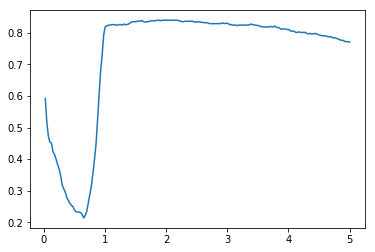

In [6]:
hellingergrid = grid_search_nonparametric(0, 5, 200, NonParametricClassifier, train, test, ["Pop", "Rap"], "hellinger", False)

# Rank-based classification

The previous methods have only utilized the differencing of word probabilities. This only measures the distance between probability distributions vertically. We also experimented with measuring the distributions horizontally by utilizing ideas from the Mann-Whitney $U$ test.

### Mann-Whitney

The basic idea is this: build empirical word distributions for each genre in the training set. Calculate word ranks by ranking words lower if they appear more and vice veraa. For new examples in the validation set, calculate the ranks of each word in the example. Given a genre, if the word does not exist in the empirical word distribution, then assign it a rank of $d / \alpha$ where $d$ is the size of the vocabulary and $\alpha$ is a parameter to be grid searched over. The motivation behind this idea is words that have not been seen in the training set will most likely not have an easily determined rank; there could be many other unseen words with lower ranking.

Below is a graph of our accuracy while grid searching over values of $\alpha$ between 0.01 and 2. Our maximum accuracy is 76.9% with $\alpha = 0.71$. This method performs poorly compared to the previous two. We hypothesize this is due to the small amount of text data: we only have a vocabulary size of 23944 different words.

Best accuracy: 0.7692307692307693
Parameter 0.7100000000000001


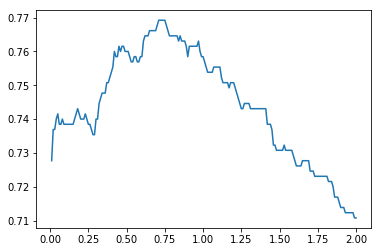

In [7]:
mwgrid = grid_search_cdf(0.01, 2, 200, CDFClassifier, train, test, ["Pop", "Rap"], "Mann-Whitney");

# Comparison to standard algorithms

To see how well our classification technique perform relative to standard classification algorithms, we also run Bernoulli Naive Bayes, Multinomial Naive Bayes, xgboost, and a feedforward neural network on the same training and validation set. From this point on, our data are vectorized into word frequency vectors.

### Naive Bayes - Bernoulli

In [6]:
X_train, y_train, X_test, y_test = prepare_binary_data(train, test)

The Bernoulli version of Naive Bayes outperforms our best result of 84%. Below is a plot of accuracies while grid searching over the smoothing parameter $\alpha$ between values of $0$ and $1$. The best accuracy of 85.5% was obtained with $\alpha = 0.005$. 

Best accuracy: 0.8553846153846154
Parameter 0.005025125628140704


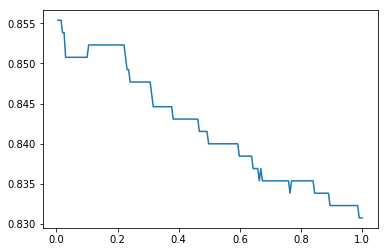

In [9]:
bernoulligrid = {}
grid2 = {}

for n in np.linspace(0, 1, 200)[1:]:
    clf = BernoulliNB(alpha = n)
    clf.fit(X_train, y_train)
    bernoulligrid.update({n: confusion_matrix(clf.predict(X_test), y_test)})
    grid2.update({n: np.diag(bernoulligrid[n]).sum() / bernoulligrid[n].sum()})
    
best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
print("Best accuracy:", best[1])
print("Parameter", best[0])
    
plt.plot([i for i in grid2], [grid2[i] for i in grid2]);

### Naive Bayes - Multinomial

Our best result outperforms the multinomial version of Naive Bayes. Below is an accuracy plot while grid searching over $\alpha$ between $0$ and $1$. Our best accuracy was 82.77% with $\alpha = 0.281$.

Best accuracy: 0.8276923076923077
Parameter 0.2814070351758794


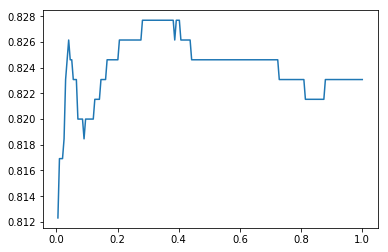

In [10]:
multigrid = {}
grid2 = {}

for n in np.linspace(0, 1, 200)[1:]:
    clf = MultinomialNB(alpha = n)
    clf.fit(X_train, y_train)
    multigrid.update({n: confusion_matrix(clf.predict(X_test), y_test)})
    grid2.update({n: np.diag(multigrid[n]).sum() / multigrid[n].sum()})
    
best = sorted(grid2.items(), key = lambda x: x[1], reverse = True)[0]
print("Best accuracy:", best[1])
print("Parameter", best[0])
    
plt.plot([i for i in grid2], [grid2[i] for i in grid2]);

### xgboost

Our learning rate is set at $0.2$. To prevent overfitting, new trees only use 90% of the training data. We utilize both $\ell_1$ and $\ell_2$ regularization and we grid search over both parameters within values of $0$ and $1$. Surprisingly, our maximum accuracy of 84.6% was obtained with a $\ell_1$ parameter of 0.8 and a $\ell_2$ parameter of $0.2$.

In [7]:
y_train_binary = convert_genre(y_train)
y_test_binary = convert_genre(y_test)

In [ ]:
dtrain = xgb.DMatrix(X_train, label = y_train_binary)
dtest = xgb.DMatrix(X_test, label = y_test_binary)
evallist = [(dtrain, 'train'), (dtest, 'eval')]

grid = {}
dims = 10

for l1 in np.linspace(0, 1, dims):
    for l2 in np.linspace(0, 1, dims):   
        param = {'max_depth': 1000, 'eta': 0.2, 'silent': 1, 'objective': 'binary:logistic', "alpha": l1,
                 "lambda": l2, "subsample": 0.9}
        bst = xgb.train(params = param, dtrain = dtrain, num_boost_round = 200, evals = evallist, early_stopping_rounds = 50)
        cfmat = confusion_matrix(bst.predict(dtest).round(), y_test_binary)
        grid.update({(l1, l2): np.diag(cfmat).sum() / cfmat.sum()})

In [9]:
mat = np.zeros((dims, dims))
row = 0
col = 0
for (r, c) in grid:
    mat[row, col] = grid[(r, c)]
    col += 1
    if (col) % dims == 0:
        if (row, col) == (0, 1):
            continue
        col = 0
        row += 1

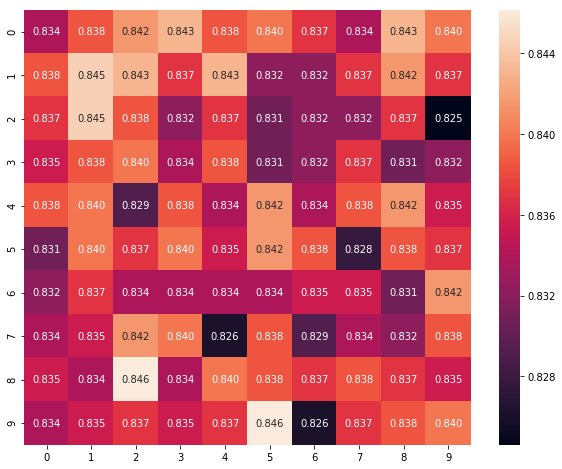

In [10]:
fig = plt.figure(figsize = (10, 8))
sns.heatmap(mat, annot = True, fmt = ".3f");

### Feedforward Neural Network

Finally, we run a four-layer feedforward neural network on our data. Each layer uses the sigmoid activation function and no regularization was used on any layer. We use the SGD optimizer with a learning rate of 0.01. No grid search was performed on the number of neurons per layer (although we probably should). Our batch size was 2 because larger batch sizes tended to destroy learning before it even started. This is most likely because we only have 2636 training samples. Our best validation accuracy was 82.77%.

In [ ]:
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

from tensorflow import Session, ConfigProto
sess = Session(config=ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [13]:
arch = [
    Dense(256, input_dim = 23944, activation = "sigmoid"),
    Dense(64, activation = "sigmoid"),
    Dense(8, activation = "sigmoid"),
    Dense(2, activation = "sigmoid"),
    Dense(1, activation = "sigmoid")
]

model = Sequential(arch)

model.compile(
    optimizer = SGD(lr = 0.01),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

filepath = "..//..//..//..//data//NN weights//weights-improvement-{epoch:02d}-{val_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True,
                             mode='max')
callbacks_list = [checkpoint]

history = model.fit(
    np.array(X_train), 
    np.array(y_train_binary),
    callbacks = callbacks_list,
    verbose = 1, 
    epochs = 20,
    batch_size = 2,
    validation_data = [np.array(X_test), np.array(y_test_binary)]
)

Train on 2636 samples, validate on 650 samples
Epoch 1/20
2636/2636 [==============================] - 13s 5ms/step - loss: 0.6937 - acc: 0.5440 - val_loss: 0.6827 - val_acc: 0.5708

Epoch 00001: val_acc improved from -inf to 0.57077, saving model to ..//..//..//..//data//NN weights//weights-improvement-01-0.5708.h5
Epoch 2/20
2636/2636 [==============================] - 11s 4ms/step - loss: 0.6865 - acc: 0.5577 - val_loss: 0.6820 - val_acc: 0.5708

Epoch 00002: val_acc did not improve from 0.57077
Epoch 3/20
2636/2636 [==============================] - 11s 4ms/step - loss: 0.6858 - acc: 0.5577 - val_loss: 0.6821 - val_acc: 0.5708

Epoch 00003: val_acc did not improve from 0.57077
Epoch 4/20
2636/2636 [==============================] - 12s 4ms/step - loss: 0.6850 - acc: 0.5577 - val_loss: 0.6813 - val_acc: 0.5708

Epoch 00004: val_acc did not improve from 0.57077
Epoch 5/20
2636/2636 [==============================] - 11s 4ms/step - loss: 0.6837 - acc: 0.5577 - val_loss: 0.6793 - val_a

In [24]:
def plot_embedding(encoder, X, Y):
    fig = plt.figure(figsize = (10, 6))
    h = encoder.predict(np.array(X))
    y_tester = np.array(Y)
    for i in range(2):
        sel = y_tester == i
        plt.plot(h[sel, 0], h[sel, 1], '.', label='Group %d' % i, markersize = 3, alpha = 0.8)
    plt.title('MLP embedding - test data')
    plt.legend()
    plt.show()

As an aside, below is the embedding of our test data within our neural network. We can see that the neural network has learned a linearly separable representation of our frequency vectors.

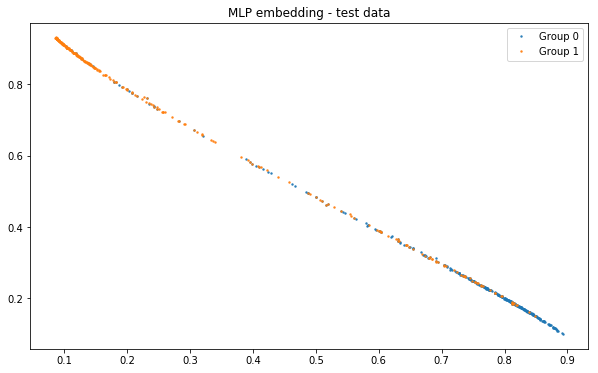

In [25]:
nn = load_model("..//..//..//..//data//NN weights//weights-improvement-17-0.8277.h5")
model_tmp = Sequential(nn.layers[:-1])
plot_embedding(model_tmp, X_test, y_test_binary)

# Results

Below is a table summarizing the performance of each algorithm on the validation set.


| KL    | Hellinger | Mann-Whitney | NB-Bernoulli | NB-Multinomial | xgboost | Neural network |
|:-----:|:---------:|:------------:|---|---|---|:---:|
|0.8262|  0.84   |    0.769    |<b>0.85538|0.82769|0.846|0.8277|

The text classification method we developed achieved a maximum accuracy of 84% on the validation set. This outperformed the neural network and the multinomial Naive Bayes and does almost as well as `xgboost`. Out of the algorithms we used, the Bernoulli version of Naive Bayes achieved the best accuracy of 85.538%.

While our algorithm does not outperform Naive Bayes, our method shows that a simple comparison of word frequencies does almost as well as Naive Bayes.